# Sound classification

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import IPython.display as ipd

In [88]:
%matplotlib inline
%load_ext tensorboard

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Data Loading and preprocessing

In [89]:
CSV_FILE_PATH = "data/esc50.csv"  # path of csv file
DATA_PATH = "data/audio/44100/" # path to folder containing audio files

In [90]:
#reading the csv file
df = pd.read_csv(CSV_FILE_PATH)
df

filename  fold  target        category  esc10  src_file take
0      1-100032-A-0.wav     1       0             dog   True    100032    A
1     1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2     1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3     1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4     1-101296-A-19.wav     1      19    thunderstorm  False    101296    A
...                 ...   ...     ...             ...    ...       ...  ...
1995   5-263831-B-6.wav     5       6             hen  False    263831    B
1996  5-263902-A-36.wav     5      36  vacuum_cleaner  False    263902    A
1997   5-51149-A-25.wav     5      25       footsteps  False     51149    A
1998    5-61635-A-8.wav     5       8           sheep  False     61635    A
1999     5-9032-A-0.wav     5       0             dog   True      9032    A

[2000 rows x 7 columns]

In [91]:
class_selection = [
    "thunderstorm",
    "rain",
    "sea_weaves",
    "dog",
    "cat",
    "chirping_birds",    
    "breathing",
    "keyboard_typing",
    "coughing",
    "drinking_sipping",
    "car_horn"
]

In [92]:
df_sel = df[df["category"].isin(class_selection)]
classes = df_sel['category'].unique()

In [93]:
classes

array(['dog', 'chirping_birds', 'thunderstorm', 'keyboard_typing',
       'car_horn', 'drinking_sipping', 'rain', 'breathing', 'coughing',
       'cat'], dtype=object)

In [94]:
class_dict = {i:x for x,i in enumerate(classes)}
class_dict

{'dog': 0,
 'chirping_birds': 1,
 'thunderstorm': 2,
 'keyboard_typing': 3,
 'car_horn': 4,
 'drinking_sipping': 5,
 'rain': 6,
 'breathing': 7,
 'coughing': 8,
 'cat': 9}

In [95]:
df_sel.loc[:, 'target'] = df_sel['category'].map(class_dict)

In [100]:
sample_list = df_sel.sample(10)["filename"].to_list()

In [103]:
import shutil
def copy_files(file_list, source_dir, destination_dir):
    for file_name in file_list:
        source_path = source_dir + '/' + file_name
        destination_path = destination_dir + '/' + file_name
        shutil.copy(source_path, destination_path)


source_dir = 'data/audio/44100'
destination_dir = 'data/samples'

# copy_files(sample_list, source_dir, destination_dir)


### Feature engineering and data visualization

In [52]:
# select a sample 
sample_df = df_sel.drop_duplicates(subset=['target'])
sample_df

filename  fold  target          category  esc10  src_file take
0     1-100032-A-0.wav     1       0               dog   True    100032    A
1    1-100038-A-14.wav     1       1    chirping_birds  False    100038    A
4    1-101296-A-19.wav     1       2      thunderstorm  False    101296    A
36      1-137-A-32.wav     1       3   keyboard_typing  False       137    A
53    1-17124-A-43.wav     1       4          car_horn  False     17124    A
61    1-17295-A-29.wav     1       5  drinking_sipping  False     17295    A
62    1-17367-A-10.wav     1       6              rain   True     17367    A
76    1-18631-A-23.wav     1       7         breathing  False     18631    A
84    1-19111-A-24.wav     1       8          coughing  False     19111    A
175    1-34094-A-5.wav     1       9               cat  False     34094    A

In [53]:
# computing mel spectrograms

signals = {}
mel_spectrograms = {}
mfccs = {}

for i, row in tqdm(sample_df.iterrows()):  # every row will be like [[index], [filename , target , category]]
    signal , rate = librosa.load(DATA_PATH+ row["filename"])
    signals[row["category"]] = signal    # fill signal for each category. eg. signal["dog"] = signal of dog sound
    
    mel_spec = librosa.feature.melspectrogram(y=signal , sr=rate ,  n_fft=2048, hop_length=512)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)  #visualizing mel_spectrogram directly gives black image. So, coverting from power_to_db is required
    mel_spectrograms[row["category"]] = mel_spec
    
    mfcc = librosa.feature.mfcc(y=signal , sr=rate , n_mfcc=13, dct_type=3)
    mfccs[row["category"]] = mfcc

10it [00:00, 74.56it/s]


In [54]:
sample_df.iloc[0]["filename"]

'1-100032-A-0.wav'

In [55]:
# Reproduce some audio samples
print(sample_df.iloc[0]["category"])
ipd.Audio(DATA_PATH + sample_df.iloc[0]["filename"])
print(sample_df.iloc[1]["category"])
ipd.Audio(DATA_PATH + sample_df.iloc[1]["filename"])
print(sample_df.iloc[2]["category"])
ipd.Audio(DATA_PATH + sample_df.iloc[2]["filename"])

dog


chirping_birds


thunderstorm


In [56]:
import seaborn as sns

def plot_signal_seaborn(signal):
    """
    this function will take the signal dictionary and plot the signals using seaborn
    """
    sns.set(style='whitegrid')
    fig , axes = plt.subplots(nrows=2 , ncols=5 , sharex =False ,sharey=True,figsize=(20,5))
    fig.suptitle('Time series',size=15)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            sns.lineplot(data=list(signals.values())[i], ax=axes[x,y])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

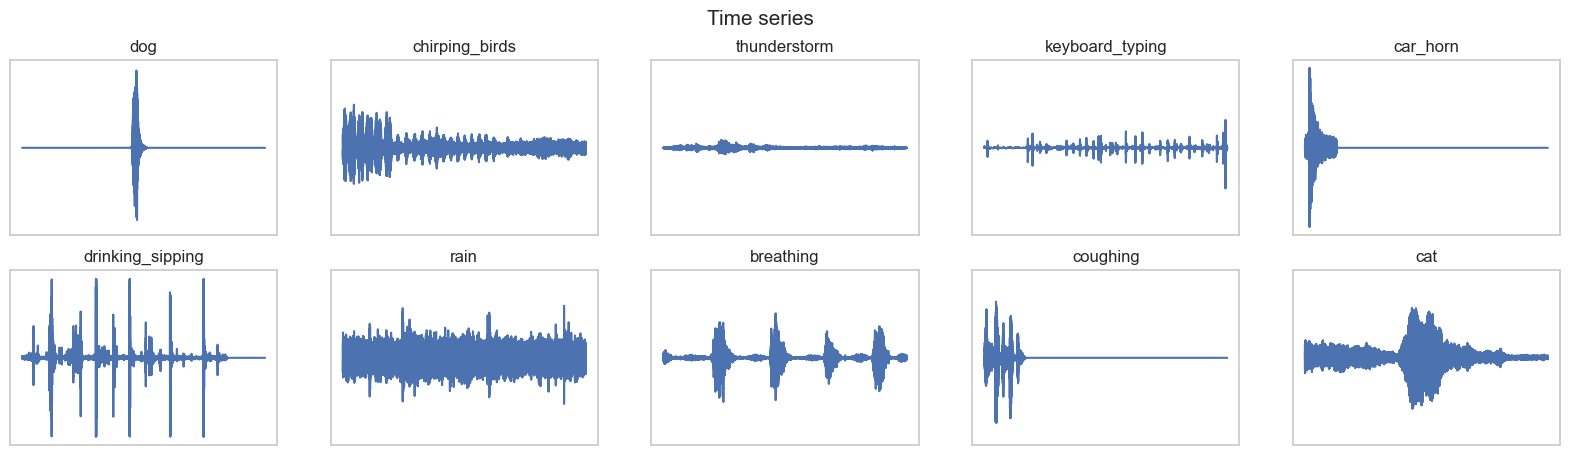

In [57]:
plot_signal_seaborn(signals)

In [58]:
def dis_feature(mfccs, cmap=None):
    """
    this function will take the mfcc/mel_spectrogram dictionary and plot the signals
    """
    fig ,axes= plt.subplots(nrows=2 , ncols=5 , sharex=False, sharey=True , figsize=(40,10))
    fig.suptitle('mel')
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i], cmap=cmap,interpolation='nearest')
            # axes[x,y].get_xaxis().set_visible(False)
            # axes[x,y].get_yaxis().set_visible(False)
            i+=1

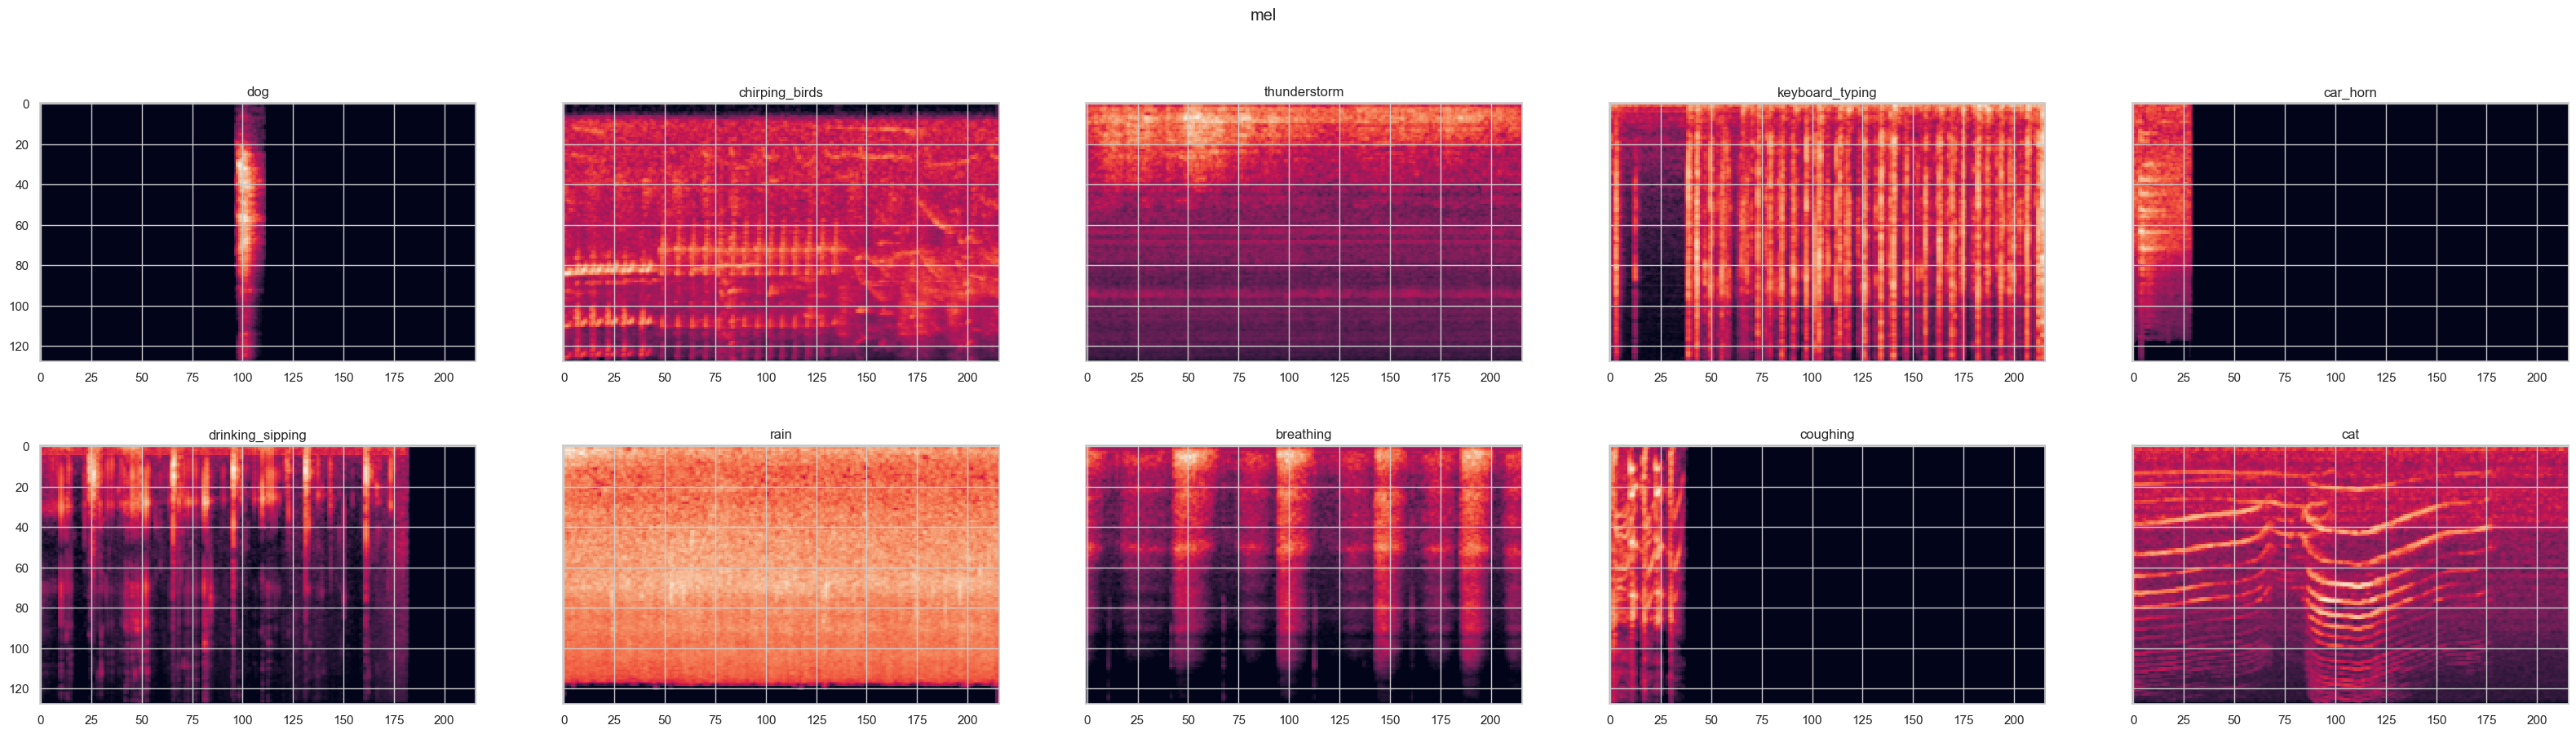

In [59]:
dis_feature(mel_spectrograms)

### Audio data augmentation 

In [60]:
df_sel.head()

filename  fold  target        category  esc10  src_file take
0    1-100032-A-0.wav     1       0             dog   True    100032    A
1   1-100038-A-14.wav     1       1  chirping_birds  False    100038    A
4   1-101296-A-19.wav     1       2    thunderstorm  False    101296    A
5   1-101296-B-19.wav     1       2    thunderstorm  False    101296    B
14   1-110389-A-0.wav     1       0             dog   True    110389    A

In [61]:
df_train, df_val = train_test_split(df_sel, test_size=0.2, random_state=2023)

In [62]:
def add_noise(data, scale=0.05):
    noise = np.random.normal(0, scale, len(data))
    audio_noisy = data + noise
    return audio_noisy
    
def pitch_shifting(data, sr=16000):
    sr  = sr
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'),  sr=sr, n_steps=pitch_change, 
                                          bins_per_octave=bins_per_octave)
    return data

def random_shift(data):
    timeshift_fac = 0.2 *2*(np.random.uniform()-0.5)  # up to 20% of length
    start = int(data.shape[0] * timeshift_fac)
    if (start > 0):
        data = np.pad(data,(start,0),mode='constant')[0:data.shape[0]]
    else:
        data = np.pad(data,(0,-start),mode='constant')[0:data.shape[0]]
    return data

def volume_scaling(data):
    dyn_change = np.random.uniform(low=1.5,high=2.5)
    data = data * dyn_change
    return data
    
def time_stretching(data, rate=1.5):
    input_length = len(data)
    streching = data.copy()
    streching = librosa.effects.time_stretch(streching, rate=rate)
    
    if len(streching) > input_length:
        streching = streching[:input_length]
    else:
        streching = np.pad(streching, (0, max(0, input_length - len(streching))), "constant")
    return streching

def audio_augmentation(file, aug):
    directory = 'ESC-50-augmented-data/'
    if not os.path.exists(directory):
        os.makedirs(directory)
    aug = np.array(aug,dtype='float32').reshape(-1,1)
    sf.write(directory+'/'+ file, aug, 16000, 'PCM_24')

In [63]:
import IPython.display as ipd

row = df_sel.iloc[10]

file_name = row["filename"]
print(row["category"])
signal , sr = librosa.load(DATA_PATH+file_name)
print("original")
ipd.Audio(signal, rate=sr)

noised = add_noise(signal, 0.005)
print("noised")
ipd.Audio(noised, rate=sr) 

shifted = pitch_shifting(signal)

print("pitch shifted")
ipd.Audio(shifted, rate=sr)

print("random shifted")
r_shifted = random_shift(signal)
ipd.Audio(r_shifted, rate=sr)

print("volume scaled")
vol_scaled = volume_scaling(signal)
ipd.Audio(vol_scaled, rate=sr)

print("time stretching")
time_stretched = time_stretching(signal)
len(time_stretched)
ipd.Audio(time_stretched, rate=sr)



breathing
original


noised


pitch shifted


random shifted


volume scaled


time stretching


110250

In [64]:
def augment_df(df):

    totals = []
    
    for i, row in df.iterrows():
        df_temp = pd.DataFrame()
        signal , sr = librosa.load(DATA_PATH+row["filename"])
        aug_signals = {
            "original": signal,
            "noised": add_noise(signal, 0.005),
            "pitch_shift": pitch_shifting(signal),
            "random_shifted": random_shift(signal),
            "vol_scaled": volume_scaling(signal),
            "time_stretched": time_stretching(signal)
        }

        df_temp = df_temp._append([row]*len(aug_signals),ignore_index=True)

        # signal_arrays = []
        # signal_types = []
        # for i, (key, val) in enumerate(aug_signals.items()):
        #     signal_arrays.append(val)
        #     signal_types.append(key)

        df_temp["signal"] = aug_signals.values()
        df_temp["type"] = aug_signals.keys()
        
        totals.append(df_temp)
            
    return pd.concat(totals)

def load_signals(df):
    df["signal"] = df["filename"].apply(lambda x: librosa.load(DATA_PATH+x)[0])
    return df

In [65]:
df_train_aug = augment_df(df_train)

In [66]:
df_val = load_signals(df_val)

In [68]:
def df_to_tf(df):
    sr = 22050
    X , y = [] , []
    for i, data in tqdm(df.iterrows()):
        mfcc_ = librosa.feature.mfcc(y=data["signal"], sr=sr, n_mfcc=13)
        X.append(mfcc_)
        y.append(data["target"])

    # convert list to numpy array
    X = np.array(X) 
    y = np.array(y)

    #one-hot encoding the target
    y = tf.keras.utils.to_categorical(y , num_classes=10)

    # our tensorflow model takes input as (no_of_sample , height , width , channel).
    # here X has dimension (no_of_sample , height , width).
    # So, the below code will reshape it to (no_of_sample , height , width , 1).
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    return X, y

In [69]:

X_train, y_train = df_to_tf(df_train_aug)
X_val, y_val = df_to_tf(df_val)

1920it [00:09, 204.31it/s]
80it [00:00, 182.22it/s]


In [70]:
X_train.shape
y_train.shape

(1920, 13, 216, 1)

(1920, 10)

## Modelling

In [71]:
# Modeling
INPUTSHAPE = (13,216,1)

In [72]:
LOGDIR = "logs"
CPKT = "cpkt/"

In [73]:
#this callback is used to prevent overfitting.
callback_1 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.01, patience=60, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

#this checkpoint saves the best weights of model at every epoch
callback_2 = tf.keras.callbacks.ModelCheckpoint(
    CPKT, monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch', options=None
)

#this is for tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOGDIR)

In [74]:
from keras.layers import Dropout, BatchNormalization
def create_model():
    INPUTSHAPE = (13,216,1)
    model = models.Sequential([
                          layers.Conv2D(16 , (3,3),activation = 'relu',padding='valid', input_shape = INPUTSHAPE),
                          BatchNormalization(),
                          layers.Conv2D(64, (3,3), activation='relu',padding='valid'),
                          BatchNormalization(),
                          layers.Conv2D(32, (3,3), activation='relu',padding='valid'),
                          BatchNormalization(),
                          layers.GlobalAveragePooling2D(),
                          Dropout(0.5),
                          layers.Dense(32 , activation = 'relu'),
                          Dropout(0.5),
                          layers.Dense(10 , activation = 'softmax')
    ])
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'acc')
    return model

### Cross validation

In [75]:
CROSS_VALIDATION = False

if CROSS_VALIDATION: 
    df_augmented = augment_df(df_sel)

    n_folds = 2
    fold_accuracy = []

    for i in range(1, n_folds + 1):

        # split folds
        df_train_fold = df_augmented[df_augmented["fold"] !=i]
        df_val_fold = df_augmented[(df_augmented["fold"] == i) & (df_augmented["type"] == "original")] # Select only the original data for the validation fold.

        # convert to tensors
        X_train, y_train =  df_to_tf(df_train_fold)
        X_val, y_val = df_to_tf(df_val_fold)

        model = create_model()
        model.fit(X_train,y_train,
                validation_data=(X_val,y_val),
                epochs=120,
                callbacks = [callback_1 , callback_2 , tensorboard_callback])
        
        _, accuracy = model.evaluate(X_val, y_val, verbose=0)
        fold_accuracy.append(accuracy)

    print(f"Average Accuracy: {np.mean(fold_accuracy) * 100}")


In [76]:
inverted_dict = {value: key for key, value in class_dict.items()}

def sample_inference(df):
    row = df.sample(1)

    ipd.Audio(row["signal"].iloc[0], rate=sr)
    print(row["target"])
    xp, yp = df_to_tf(row)
    prediction = model.predict(xp)  # Get the model's prediction

    # # The prediction is an array of probabilities for each class. 
    # # To get the class with the highest probability, you can use argmax
    predicted_class = np.argmax(prediction)

    print(f"The predicted class is {inverted_dict[predicted_class]}")

### Training and validation

In [77]:
# Having fined tuned the model, now split data in training and validation

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 11, 214, 16)       160       
                                                                 
 batch_normalization (BatchN  (None, 11, 214, 16)      64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 212, 64)        9280      
                                                                 
 batch_normalization_1 (Batc  (None, 9, 212, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 210, 32)        18464     
                                                                 
 batch_normalization_2 (Batc  (None, 7, 210, 32)       1

In [78]:
# split data
df_train, df_val = train_test_split(df_sel)

# for validation use only original data, exclude augmented. 
df_train = augment_df(df_train)
df_val = load_signals(df_val)

print("training size", df_train.shape)
print("validation size", df_val.shape)

# convert to tensors
X_train, y_train =  df_to_tf(df_train)
X_val, y_val = df_to_tf(df_val)

TRAIN_MODEL = False

if TRAIN_MODEL:
        model = create_model()
        model.fit(X_train,y_train,
                validation_data=(X_val,y_val),
                epochs=90,
                callbacks = [callback_1 , callback_2 , tensorboard_callback])

training size (1800, 9)
validation size (100, 8)


1800it [00:08, 201.80it/s]
100it [00:00, 206.56it/s]


In [40]:
df_val.sample(5)

filename  fold  target      category  esc10  src_file take  \
1973   5-259169-A-5.wav     5       9           cat  False    259169    A   
1625  5-156999-C-19.wav     5       2  thunderstorm  False    156999    C   
1148  3-243726-A-43.wav     3       4      car_horn  False    243726    A   
750    2-82455-A-23.wav     2       7     breathing  False     82455    A   
296     1-59513-A-0.wav     1       0           dog   True     59513    A   

                                                 signal  
1973  [0.074713066, 0.1878967, 0.19880958, 0.1556799...  
1625  [-0.022853062, -0.033742126, -0.03178723, -0.0...  
1148  [-0.00044537033, -0.00040019804, 0.00097464083...  
750   [-0.014306096, -0.02576382, -0.019153383, -0.0...  
296   [0.0016863123, 0.0030235946, 0.0026457086, 0.0...

In [37]:
import tensorflow as tf
# Save the model
model.save("model/model.h5")

In [36]:
# Load the model
model = tf.keras.models.load_model("model/model.h5")

Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-01-11 21:15:40.920364: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-11 21:15:40.920521: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [37]:


# Perform prediction on a single instance

X = []
sample_path = df_val.iloc[0]["filename"]
signal, sr = librosa.load(DATA_PATH+sample_path)
mfcc_ = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
X.append(mfcc_)
X = np.array(X)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)



# Perform prediction
# prediction = model.predict(reshaped_sample)

# # Get the predicted class
# predicted_class = np.argmax(prediction)

# # Print the predicted class
# print(f"The predicted class is {predicted_class}")


In [38]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

with open('model/sound-model.tflite', 'wb') as f_out:
    f_out.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/rz/hqy45d3569g71gtmcbpt6vkr0000gp/T/tmpx04a2u54/assets


INFO:tensorflow:Assets written to: /var/folders/rz/hqy45d3569g71gtmcbpt6vkr0000gp/T/tmpx04a2u54/assets
2024-01-11 21:15:48.987204: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-01-11 21:15:48.987216: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-01-11 21:15:48.987653: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/rz/hqy45d3569g71gtmcbpt6vkr0000gp/T/tmpx04a2u54
2024-01-11 21:15:48.989667: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2024-01-11 21:15:48.989677: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /var/folders/rz/hqy45d3569g71gtmcbpt6vkr0000gp/T/tmpx04a2u54
2024-01-11 21:15:48.994542: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2024-01-11 21:15:48.996115: I tensorflow/cc/saved_model/load

123432

In [39]:
!pip install keras-image-helper

In [40]:
!pip install --extra-index-url https://google-coral.github.io/py-repo/ tflite_runtime

Looking in indexes: https://pypi.org/simple, https://google-coral.github.io/py-repo/


In [42]:
# import tensorflow.lite as tflite
import tflite_runtime.interpreter as tflite
from keras_image_helper import create_preprocessor

ImportError: generic_type: type "InterpreterWrapper" is already registered!

In [44]:


interpreter = tflite.Interpreter(model_path='model/sound-model.tflite')
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

ModuleNotFoundError: No module named 'tflite_runtime'

In [ ]:
preprocessor = create_preprocessor('xception', target_size=(299, 299))